In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fname = 'train.csv'
df = pd.read_csv(fname, index_col='Id')
n_examples, n_features = df.shape
# df_test = pd.read_csv('train.csv', index_col='Id')

pd.set_option('display.max_rows', 90)
pd.set_option("display.precision", 2)
df.head()

y = df['SalePrice']
# df = df.drop(columns='SalePrice')
y.shape, df.shape

((1460,), (1460, 80))

In [26]:
means_neigh = (pd.concat([df['Neighborhood'], y], axis=1)
                     .pivot_table(index='Neighborhood', values='SalePrice', aggfunc='mean')
                  )
means_neigh.rename(columns={"SalePrice":"means_neigh"})

,means_neigh
Neighborhood,
Blmngtn,194870.88
Blueste,137500.00
BrDale,104493.75
BrkSide,124834.05
ClearCr,212565.43
CollgCr,197965.77
Crawfor,210624.73
Edwards,128219.70
Gilbert,192854.51


# Getting rid of not interesting features

In [2]:
lst = ['MoSold', 'YrSold', 'BldgType',      # not so useful information
       'MasVnrType', 'MasVnrArea',         # nobody cares about masonry
       'Heating', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'LotConfig',
       'GarageArea',                       # redundant, highly correlated with GarageCars (r ~ 0.88)
       'GarageYrBlt',                      # redundant (almost always == YearBuilt)
       'GarageType', 'HouseStyle', 
       'MiscFeature', 'MiscVal']

df.drop(columns=lst, inplace=True)

# Separation of numerical-valued features from nominal


In [3]:
numerical = df.select_dtypes(include=[np.number])
nominal = df.select_dtypes(exclude=[np.number])

# Missing values

Numerical:
- LotFrontage      259
- GarageYrBlt       81
- MasVnrArea         8

Nominal:
- PoolQC           1445
- MiscFeature      1398
- Alley            1362
- Fence            1171
- FireplaceQu       686
- GarageType         81
- GarageFinish       81
- GarageQual         81
- GarageCond         81
- BsmtExposure       38
- BsmtFinType2       38
- BsmtCond           37
- BsmtFinType1       37
- BsmtQual           37
- Electrical          1

In [4]:
def get_missed_mask(column_name):
    return pd.isna(df[column_name])


lst = ['PoolQC', 'Fence', 'Alley', 'FireplaceQu', 'GarageFinish', 
       'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtCond', 'BsmtQual', 
       'Electrical']
non_available_label = 'No'
df.loc[:, lst] = df[lst].fillna(non_available_label)


#LotFrontage      259
# determine missed frontage as mean among houses with the same number of cars
mask_missed = get_missed_mask('LotFrontage')
missed = df[mask_missed]
mean_frontages = (df[['LotFrontage', 'GarageCars']]
                  .groupby('GarageCars')
                  .mean()
                  .squeeze() 
                 )
def my_fillna_frontage(r): 
    r.loc['LotFrontage'] = mean_frontages.loc[r['GarageCars']]
    return r

df.loc[mask_missed] = missed.apply(my_fillna_frontage, axis=1)

KeyError: 'Neighborhood'

# OneHot encoding

In [5]:
df = df.merge(pd.get_dummies(df[['SaleCondition', 'MSZoning']]),
              left_index=True, 
              right_index=True, 
              how='left')
df.drop(columns=['SaleCondition', 'MSZoning'], inplace=True)

Special case:
3 one-hot vectors from features Condition1 and Condition2:

first: Artery  or Feedr is present

second: PosA or PosN

third: RRAe or RRAn or RRNe or RRNn

In [6]:

def get_dummies_if_any(df, lst):
    return  ((np.isin(df['Condition1'], lst) |
              np.isin(df['Condition2'], lst))
                     .astype(int)
            )

df['NearArtery_or_Feedr'] = get_dummies_if_any(df, ['Artery', 'Feedr'])
df['PositiveFeat'] = get_dummies_if_any(df, ['PosA', 'PosN'])
df['NearRailroad'] = get_dummies_if_any(df, ['RRAe', 'RRAn', 'RRNe', 'RRNn'])
df.drop(columns=['Condition1','Condition2'], inplace=True)

In [7]:
df.head()

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LandSlope,Neighborhood,...,SaleCondition_Normal,SaleCondition_Partial,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,NearArtery_or_Feedr,PositiveFeat,NearRailroad
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,Pave,No,Reg,Lvl,AllPub,Gtl,CollgCr,...,1,0,0,0,0,1,0,0,0,0
2,20,80.0,9600,Pave,No,Reg,Lvl,AllPub,Gtl,Veenker,...,1,0,0,0,0,1,0,1,0,0
3,60,68.0,11250,Pave,No,IR1,Lvl,AllPub,Gtl,CollgCr,...,1,0,0,0,0,1,0,0,0,0
4,70,60.0,9550,Pave,No,IR1,Lvl,AllPub,Gtl,Crawfor,...,0,0,0,0,0,1,0,0,0,0
5,60,84.0,14260,Pave,No,IR1,Lvl,AllPub,Gtl,NoRidge,...,1,0,0,0,0,1,0,0,0,0


# Ordinal encoding

In [8]:
lst = ['PoolQC', 'KitchenQual', 
       'HeatingQC', 'ExterQual', 'ExterCond',
       'BsmtQual', 'BsmtCond', 'FireplaceQu',
       'GarageQual', 'GarageCond']
quality_map={non_available_label: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
df.loc[:, lst] = df[lst].apply(lambda c: c.map(quality_map), axis=0).fillna(0)

#================================================
def get_quality_coef(column_name, grades_to_numbers):
    return df[column_name].map(grades_to_numbers)

# mask_missed = df['Fence'] == non_available_label
# df.loc[~mask_missed, 'Fence'] = 1
# df.loc[mask_missed, 'Fence'] = 0
df['Fence'] = get_quality_coef('Fence', 
                               {non_available_label: 0}).fillna(1)
# df['BsmtExposure'] = get_quality_coef('BsmtExposure', 
#                                       {'No': 1, 'Mn': 2, 'Av': 3, 'Ex' : 4}).fillna(0)
df['BsmtQuartersQ'] = get_quality_coef('BsmtFinType1', 
                                       {'BLQ':1, 'ALQ':2, 'GLQ':3}).fillna(0) +\
                      get_quality_coef('BsmtFinType2', 
                                       {'BLQ':1, 'ALQ':2, 'GLQ':3}).fillna(0)
df['CentralAir'] = df['CentralAir'].map({'N':0, 'Y':1})
df['Electrical'] = get_quality_coef('Electrical', {'FuseP':1}).fillna(0)
# df['GarageFinish'] = get_quality_coef('GarageFinish', 
#                                       {'Fin':3, 'RFn':2, 'Unf':1}).fillna(0)
df['PavedDrive'] = get_quality_coef('PavedDrive', 
                                    {'N':1, 'P':2, 'Y':3})
df['Utilities'] = get_quality_coef('Utilities', 
                                   {'ELO':1, 'NoSeWa':2, 'NoSewr':3, 'AllPub':4}).fillna(0)
# df['LandContour'] = get_quality_coef('LandContour', 
#                                      {'Low':3, 'Bnk':2, 'Hls':1}).fillna(0)
# df['LandSlope'] =  get_quality_coef('LandSlope', 
#                                     {'Gtl':1, 'Mod':2, 'Sev':3})
df['DeductionsFunctional'] = get_quality_coef('Functional', 
                                              {'Typ':0, 'Min1':1, 'Min2':2,
                                               'Mod':3, 'Maj1':4, 'Maj2':5}).fillna(0)
df['DamageOfFunctionality'] = get_quality_coef('Functional', 
                                               {'Sev':1, 'Sal': 2}).fillna(0)
df['Street'] = get_quality_coef('Street', {'Grvl':1, 'Pave':2})
df['Alley'] = get_quality_coef('Alley', {'Grvl':1, 'Pave':2}).fillna(0)
df['Foundation'] = (df['Foundation'] != 'Wood').astype(int)

#================================================
# LotShape regularity - binary feature
df['RegularityOfShape'] = ((df['LotShape'] == 'Reg') | (df['LotShape'] == 'IR1')).astype(int)


In [9]:
# ONLY for training set!!!!!
means_neigh = (pd.concat([df['Neighborhood'], y], axis=1)
                 .pivot_table(index='Neighborhood', values='SalePrice', aggfunc='mean')
              )
means_neigh.to_csv('mean_price_of_neighbours.csv')
means_neigh

,SalePrice
Neighborhood,
Blmngtn,194870.88
Blueste,137500.00
BrDale,104493.75
BrkSide,124834.05
ClearCr,212565.43
CollgCr,197965.77
Crawfor,210624.73
Edwards,128219.70
Gilbert,192854.51


In [10]:



# # mean price among neighbours
# means_neigh = (df.groupby('Neighborhood')
#                  .agg({'SalePrice':'mean'})
#                  .rename(columns={'SalePrice':'SalePriceOfNeighbours'})
#                )
df = df.merge(means_neigh, how='left', left_on='Neighborhood', right_index=True)

# Explore correlations between features

In [11]:
df.shape

(1460, 77)

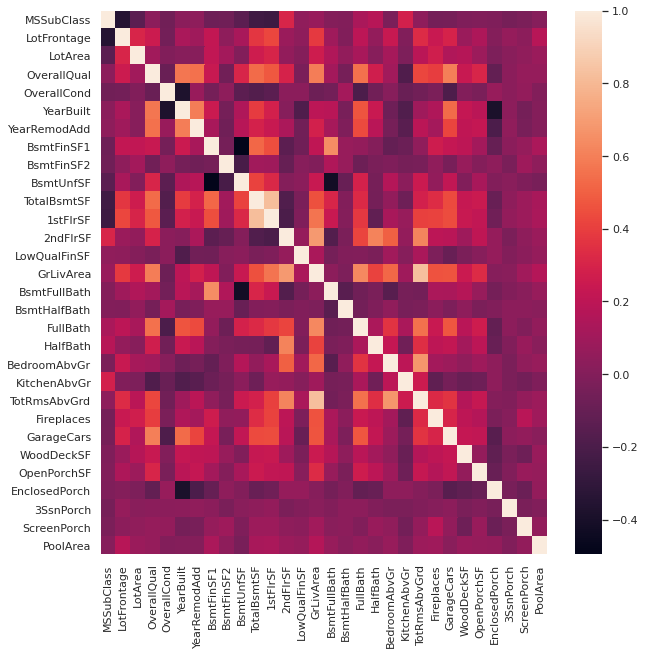

In [12]:
numeric_corr = df[numerical.columns].corr()

sns.set(rc={'figure.figsize':(10, 10)})
ax = sns.heatmap(numeric_corr);


## Highly correlated:
- TotalBsmtSF: 1FlrSF
- SalePrice: OverallQual, GrLivArea, TotalBsmtSF, 1ndFlrSf, GarageCars, 
- GrLivArea: TotalRmsAbvGr, BedroomsAbvGr, OverallQual, 1ndFlrSf, 2ndFlrSf, FullBath
- BsmtFinSF1: BsmtFullBath


## Less correlated, but still worth mentioning:
- SalePrice: YearBuilt, YearRemodAdd, TotalRoomsAbvGr, Fireplaces, FullBath
- with OverallQual: YearBuilt, YearRemodAdd, GarageCars
- with YearBuilt: YearRemodAdd
- TotalBsmtSF: OverallQual, BsmtFinSF1

# Generate new features

In [13]:
df['TotBath'] = df['BsmtFullBath'] + df['FullBath'] +\
                0.5*(df['BsmtHalfBath'] + df['HalfBath'])

# rating: combine quaility and number
df['KitchensRating'] = df['KitchenAbvGr']*df['KitchenQual']
df['FireplacesRating'] = df['Fireplaces']*df['FireplaceQu']
df['GarageRating'] = df['GarageCars']*df['GarageQual']

# Dropping of non-useful features

In [14]:
df.drop(columns=['BsmtExposure', 'BsmtFullBath', 'FullBath', 'BsmtHalfBath', 
                 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
                 '1stFlrSF', '2ndFlrSF', 
                 'LandContour', 'LandSlope', 'KitchenQual', 
                 'HeatingQC', 'ExterQual', 'ExterCond',
                 'BsmtQual', 'BsmtCond', 'FireplaceQu',
                 'GarageQual', 'GarageCond', 'PoolQC', 
                 'WoodDeckSF', 'BsmtFinSF1', 'BsmtFinSF2',
                 'BsmtUnfSF', 'MSSubClass', 'DamageOfFunctionality',
                 'OpenPorchSF', '3SsnPorch', 'ScreenPorch', 
                 'SaleCondition_AdjLand', 'SaleCondition_Family', 
                 'SaleCondition_Alloca', 'Foundation', 'LowQualFinSF',
                 'NearRailroad', 'MSZoning_FV', 'Fireplaces', 
                 'GarageCars', 'OverallCond', 'GarageFinish',
                 'SaleType'], inplace=True)
# we will drop TotRmsAbvGrd, because 
# it's redundant(highly correlated with GrLivArea) r = 0.82
df.drop(columns=['TotRmsAbvGrd'], inplace=True)
# if remodelling of house improves quality, OverallQual must
# contain this information
df.drop(columns=['YearRemodAdd'], inplace=True)
df.drop(columns=['LotShape'], inplace=True)
df.drop(columns=['BsmtFinType1', 'BsmtFinType2'], inplace=True)
df.drop(columns=['Functional'], inplace=True)
df.drop(columns=['Neighborhood'], inplace=True)

# Summary

In [15]:
print("We end up with:\n{} examples \n{} features".format(df.shape[0], df.shape[1]-1))

We end up with:
1460 examples 
31 features


In [17]:
# check if set contains NaN
print(f"missing values: {df.isna().sum().sum()}")

missing values: 0


In [18]:
#ONLY for training set
print('Correlations with target: ')
corr = df.corr()['SalePrice'].sort_values(ascending=False, key=lambda x: np.abs(x))
corr

Correlations with target: 


SalePrice                1.00e+00
OverallQual              6.85e-01
YearBuilt                6.25e-01
GarageRating             5.67e-01
TotBath                  5.10e-01
TotalBsmtSF              4.66e-01
GrLivArea                4.53e-01
MSZoning_RM             -3.89e-01
KitchensRating           3.52e-01
FireplacesRating         3.51e-01
BsmtQuartersQ            3.27e-01
SaleCondition_Partial    3.13e-01
MSZoning_RL              2.87e-01
PavedDrive               2.41e-01
LotFrontage              2.36e-01
Fence                   -2.29e-01
CentralAir               2.21e-01
NearArtery_or_Feedr     -1.90e-01
EnclosedPorch           -1.65e-01
LotArea                  1.53e-01
SaleCondition_Normal    -1.42e-01
DeductionsFunctional    -1.30e-01
MSZoning_C (all)        -1.10e-01
SaleCondition_Abnorml   -8.87e-02
RegularityOfShape       -8.40e-02
Alley                   -7.47e-02
Electrical              -4.08e-02
Street                   3.15e-02
MSZoning_RH             -3.14e-02
Utilities     

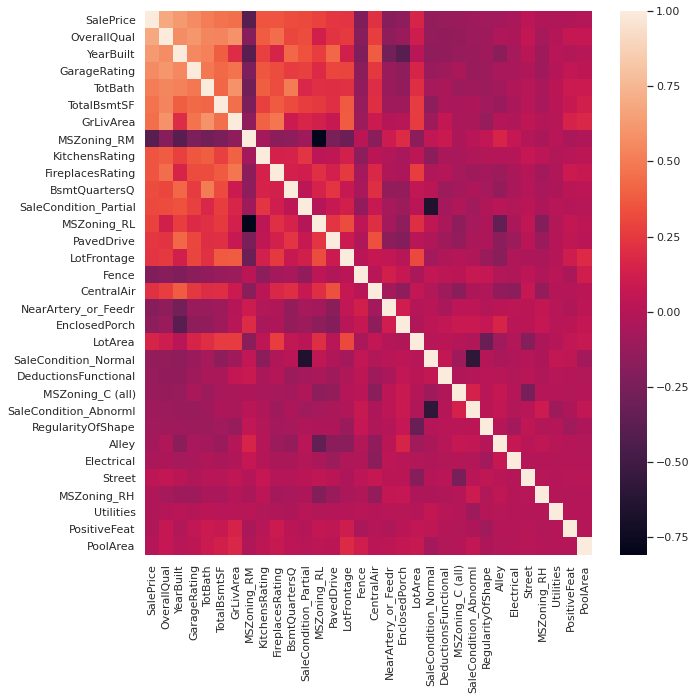

In [19]:
# sns.set(rc={'figure.figsize':(10, 10)})
lst = corr.index
sns.heatmap(df[lst].corr());


In [20]:
# hav we transformed all the categorical features into numerical?
df.select_dtypes(exclude=[np.number]).shape[1]

0

In [21]:
df.to_csv('preprocessed_' + fname)

 # Generate polynomial features from 10 selected (the most correlated with target)

In [23]:
# lst = ['OverallQual', 'SalePriceOfNeighbours', 'GrLivArea',
#        'GarageRating', 'YearBuilt',
#        'FireplacesRating', 'KitchensRating', 'BsmtQuartersQ',
#        'LotFrontage', 'LotArea']

# for feat in lst:
#     for degree in [0.5, 1, 2, 3]:
#         df[feat + ' ^ ' + str(degree)] = df[feat]**degree